In [1]:
#examine differentiable histogram loss
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = torch.nn.ReLU()
m = torch.nn.Tanh()

In [3]:
#define global constant
p = 20 #parallel runs
N = 5000 #steps per run
R = 31 #no. bins + 1
delta_t = 1e-3 #discretization of time
tau = 0.02 #membrane potential
hist_min = -2.0 #histogram range
hist_max = 2.0
mode_loc = [-1,1] #double mode Gaussian
mode_std = 0.2 #std in each mode

In [4]:
def diff_hist_p1(s,N,p,R,hist_min,hist_max):
    #R: number of bins
    #delta: bin width
    #s: sample set (p runs, N samples each run)
    #p: parallel runs
    delta = (hist_max - hist_min)/(R-1)
    s = torch.reshape(s,(p,N,1))
    r = torch.linspace(1,R-2,R-2).repeat(p,N,1)
    T_r = hist_min + r*delta
    T_rm1 = hist_min + r*delta - delta
    T_rp1 = hist_min + r*delta + delta
    return f(torch.sum(f(s-T_rm1) - 2.0*f(s-T_r) + f(s - T_rp1), axis = 1)/(N*delta))

In [5]:
class network1():
    def forward(c,w,w_o):
        r = torch.randn(12,p)
        s = torch.zeros(p,N)
        for i in range(N*20):
            r = r + delta_t * (-r + m(w@r))/tau+ (2/tau)**0.5*delta_t**0.5*c@torch.randn(12,p)
            if i%20 == 0:
            #please add sub-sampling here to prevent W from going to unrealisticly large value and generate 1 sample
            #per time step
                s[:,i//20] = w_o@r
        return s
    
    def kl_loss(s,target_hist):
        sim_hist = diff_hist_p1(s,N,p,R,hist_min,hist_max)
        #hist_cost = torch.sum(torch.sum(target_hist*torch.log((target_hist + 1e-20)/(sim_hist + 1e-20)),axis = 1))
        #hist_cost_2 = torch.sum(torch.sum(sim_hist*torch.log((sim_hist + 1e-20)/(target_hist + 1e-20)),axis = 1))
        hist_cost = torch.sum(torch.sum(torch.abs(target_hist - sim_hist)))
        out_range_cost = torch.mean(f(hist_min-s)**2 + f(s-hist_max)**2)
        #return hist_cost + hist_cost_2 + 1000*out_range_cost
        return hist_cost + 1000*out_range_cost

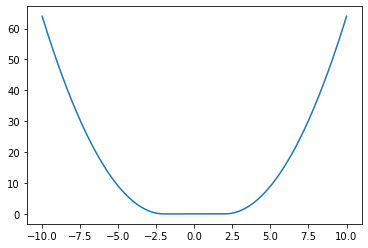

In [6]:
plt.plot(torch.linspace(-10,10,1000).detach(),f(hist_min-torch.linspace(-10,10,1000)).detach()**2 + f(torch.linspace(-10,10,1000)-hist_max).detach()**2)

In [7]:
t = np.arange(1,R-1)*(hist_max - hist_min)/(R-1) - hist_max
target_hist = 1/8**0.5/np.pi**0.5/mode_std*np.exp(-1/2/(mode_std)**2*(t-mode_loc[0])**2) + 1/8**0.5/np.pi**0.5/mode_std*np.exp(-1/2/(mode_std)**2*(t-mode_loc[1])**2)
target_hist = torch.tensor(target_hist/np.sum(target_hist))

In [7]:
'''t = np.arange(1,R-1)*(hist_max - hist_min)/(R-1) - hist_max
target_hist = np.exp(-5*np.abs(t))
target_hist = torch.tensor(target_hist/np.sum(target_hist))'''

tensor(1., dtype=torch.float64)


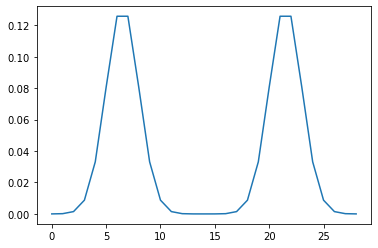

In [8]:
plt.plot(target_hist.numpy())
print(torch.sum(target_hist))

In [19]:
network1.kl_loss(torch.randn(20,5000)*0.8,target_hist)

tensor(25.7830, dtype=torch.float64)

In [21]:
network1.kl_loss(torch.tensor(np.random.laplace(scale = 0.2, size = (20,5000))),target_hist)

tensor(37.1479, dtype=torch.float64)

In [22]:
'''max_eig = True
while max_eig:
    w = torch.autograd.Variable(torch.randn(8,8),requires_grad = True).float()
    if torch.max(torch.real((torch.linalg.eig(w.detach())[0])))<1:
        max_eig = False'''

w = torch.autograd.Variable(torch.randn(12,12),requires_grad = True).float()

c = torch.autograd.Variable(torch.randn(12,12),requires_grad = True).float()
w_o = torch.autograd.Variable(torch.randn(1,12),requires_grad = True).float()

In [48]:
import sys
#loss_list = []
L = 0

#optimizer = torch.optim.Adam([w,c,w_o], 0.02)

'''for v in range(100):
    optimizer.zero_grad()
    samples = network1.forward(c,w,w_o)
    L = network1.kl_loss(samples,target_hist)
    
    L1 = L.detach().numpy().copy()
    if v%5 == 0:
        print(L1)
    loss_list.append(L1)
    
    if np.isnan(L1) == True:
        print('error')
        sys.exit(0)
        
    L.backward()
    optimizer.step()'''

optimizer = torch.optim.Adam([w,c,w_o], 0.01) 
    
for v in range(10):
    optimizer.zero_grad()
    samples = network1.forward(c,w,w_o)
    L = network1.kl_loss(samples,target_hist)
    
    L1 = L.detach().numpy().copy()
    print(L1)
    loss_list.append(L1)
    
    if np.isnan(L1) == True:
        print('error')
        sys.exit(0)
        
    L.backward()
    optimizer.step()

5.0094132383479
7.838367743481112
4.174875232711061
4.207121282187895
4.148284451194637
3.5090278294445816
3.768154400066683
3.0652024971476415
2.998701919400546
3.4113315110336724


3.4113315110336724
305


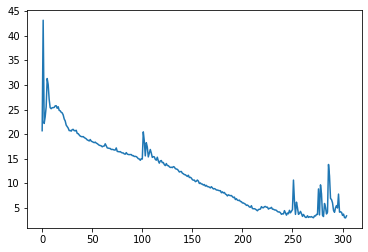

In [49]:
plt.plot(loss_list)
print(loss_list[-1])
print(len(loss_list))

In [50]:
s = network1.forward(c,w,w_o).detach()

In [51]:
s.shape

torch.Size([20, 5000])

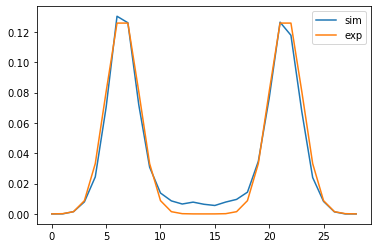

tensor(3.0916, dtype=torch.float64)


In [52]:
plt.plot(diff_hist_p1(s,N,p,R,hist_min,hist_max)[0])
#plt.plot(diff_hist_p1(torch.randn(20,5000)*0.2530,N,p,R,hist_min,hist_max)[0])
plt.plot(target_hist)
plt.legend(['sim','exp'])
plt.show()
print(network1.kl_loss(s,target_hist))

In [41]:
torch.std(s)

tensor(0.9785)

In [53]:
w_o

tensor([[-0.9036, -0.7543, -0.0566,  0.2355,  1.4349,  0.1054, -0.2438,  0.9496,
          0.6700, -0.1769,  0.1115,  0.1761]], requires_grad=True)

In [66]:
import pickle
pickle.dump([w,c,w_o], open("bimodal.p", "wb"))
with open("bimodal.p", "rb") as input_file:
    e = pickle.load(input_file)